# Sparsity-Conditioning Trade-Off : Motivating Horizontal Layers
- The goal of this tutorial is to answer the question: What is the motivation behind constructing a dynamic neural network architecture with (potentially) horizontal hidden layers using the proposed pre-processing algorithm that block-diagonalizes the state matrix in a numerically stable way.

In [1]:
# Import packages
import sys
sys.path.insert(0, "../../")
import numpy as np
import scipy.linalg as LA
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.animation import FFMpegWriter, PillowWriter
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from matplotlib import cm, colors
import os

# Import modules from dynamic neural network
from dynamic_neural_networks.utils import *
from dynamic_neural_networks.transformations.helper_functions import *
from dynamic_neural_networks.transformations.sorted_real_schur_forms import *
from dynamic_neural_networks.model.dnn import *
from dynamic_neural_networks.model.state_space_model import *
from dynamic_neural_networks.utils.helper_functions import *
from scipy import signal

expensive_asserts = False
register_matplotlib_converters()
cmap = cm.jet
current_working_directory = %pwd
my_path = current_working_directory + '/figures/scn'# Figures out the absolute path for you in case your working directory moves around.
   

Set parameters 

In [2]:
# Problem setup
# Dimensions of the LTI system
d_in = 10  # Input dimension  (<-> Source term)
d_state = 10  # State dimension  (<-> Spatial grid points)
d_out = 4  # Output dimension (<-> Temperature)
ssm_dim = [d_state, d_in, d_out]  # Dimensions of the state-space model

# Set random seed
np.random.seed(4)

# State Space Model (LTI System)
A = 0.1 * np.triu((np.random.rand(d_state, d_state)))  # State matrix
for i in range(d_state):  # Set eigenvalues of the state matrix
    A[i, i] = -4.0 + 2.5 ** (-((i)))
B = 0.5 * np.random.rand(d_state, d_in)  # Input Matrix
C = 0.5 * np.random.rand(d_out, d_state)  # Output matrix
D = -0.5 * np.random.rand(d_out, d_in)  # Feedforward matrix
ssm = state_space_model(A, B, C, D)  # State Space Model

num, den = signal.ss2tf(A, B, C, D)
# Step 3: Display the numerator and denominator
print("Numerator:", num)
print("Denominator:", den)

Numerator: [[-2.01905131e-01 -7.33177960e+00 -1.19292799e+02 -1.14469344e+03
  -7.16948059e+03 -3.06032599e+04 -9.00810271e+04 -1.80343235e+05
  -2.34673493e+05 -1.78889601e+05 -6.05059382e+04]
 [-2.92137826e-01 -1.05295918e+01 -1.69881108e+02 -1.61444656e+03
  -9.99954187e+03 -4.21319202e+04 -1.22123974e+05 -2.40023887e+05
  -3.05364072e+05 -2.26291309e+05 -7.37991186e+04]
 [-1.14396961e-01 -3.72791226e+00 -5.27521537e+01 -4.19148439e+02
  -1.99446656e+03 -5.36941014e+03 -4.88059856e+03  1.63761858e+04
   6.26100108e+04  8.66534720e+04  4.59630837e+04]
 [-3.41673150e-02 -8.79196958e-01 -7.60611409e+00  7.96359351e-01
   5.40085610e+02  4.97673604e+03  2.39514331e+04  7.02787055e+04
   1.26836181e+05  1.30164415e+05  5.84087478e+04]]
Denominator: [1.00000000e+00 3.83335081e+01 6.60799651e+02 6.74535264e+03
 4.51525787e+04 2.07091713e+05 6.59058097e+05 1.43699155e+06
 2.05429148e+06 1.73865875e+06 6.61524432e+05]


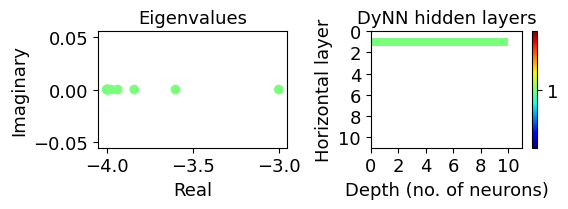

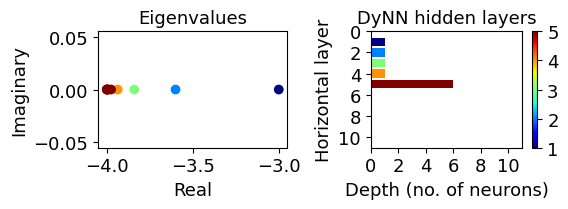

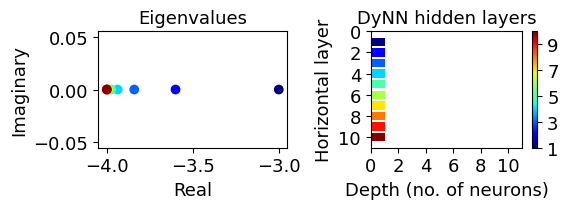

In [3]:
# Construct DyNNs for different no. of eigenvalue clusters
w_inf_norm = np.zeros((d_state, 3))
w_two_norm = np.zeros((d_state, 3))
cond_nums = np.zeros(d_state)
for i in range(d_state):
    n_clusters = i + 1
    clustering_alg = KMeans(
        n_clusters=n_clusters, random_state=0, n_init="auto", tol=1e-20
    )
    dynn = dynamic_neural_network(ssm=ssm)

    # Transform state space model, construct dynn blocks, compute weights
    dynn.fit(clustering_alg, verbose=0, show_plots=False)
    if i + 1 == 1 or i + 1 == 5 or i + 1 == 10:
        dynn.plot_architectures(
            figname="sp_con_num", fig_size=(5.8, 2.2), counter=i + 1, fontsize = 13, show_title=False
        )
        # eval(f"dynn.plot_architecture(figname='sc_t{i+1}', fig_size_1=(2.5, 2), fig_size_2=(4, 2))")
    cond_nums[i] = dynn.cond_num
    w_inf_norm[i], w_two_norm[i] = dynn.get_weights(visualize=False)

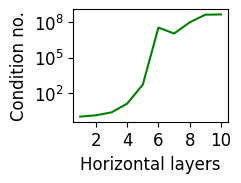

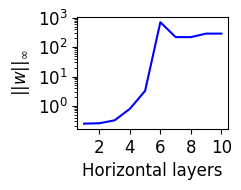

In [4]:
# Plots
plot_sparsity_conditioning_tradeoff(cond_nums, d_state, w_inf_norm, figsize=(2.5,2), fontsize=12)

Key observations: 
- Condition number $C_{tr}$ of the transformation matrix in the pre-processing algorithm grows with the number of clusters of eigenvalues (which equals the number of diagonal blocks in the transformed state matrix as well as the number of Horizontal Hidden Layers (HHLs) in the constructed DyNN) as shown in the following figure: 
<img src="sparsity_conditioning_tradeoff.jpg" width="550px">

- The computed weights also blow up as the number of horizontal layers increase. 

- To ensure numerical stability of the pre-processing algorithm: 
QR decomposition is numerically stable. However, for Bartels-Stewart algorithm, if one aggressively increases the number of diagonal blocks (eigenvalue clusters) of the state matrix, close eigenvalues are forced in different clusters and the algorithm is numerically unstable. 
If all the eigenvalues of the state matrix are close to each other, the pre-processing algorithm can always construct a dynamic neural network with a single horizontal layer by performing only the real Schur decomposition. Though, this results in a less sparse DyNN, it also leads to a much smaller condition number of the transformation matrix. One can keep increasing the number of diagonal blocks till by setting an acceptable threshold on the condition number of the transformation matrix $tol$ such that $C_{tr} < tol$. This is how one can navigate this trade-off between sparsity and condition number of the transformation matrix. Please refer to the section on pre-processing algorithm and the numerical example in the paper for details. 







# Simulation with the constructed dynamic neural network

In [5]:
# Input to a dynamic neural network and the numerical solvers
# Timesteps
t_0 = 0.0  # Initial time
t_end = 10.0  # Final time
dt = 0.1  # Time-step size
timesteps = np.arange(t_0, t_end + dt, dt)  # All time-steps

# Method to interpolate the input function within each time-step
u_interp = "piecewise_linear"  # 'piecewise_constant', 'piecewise_linear', 'sample'

# Inputs: u(t) and u'(t)
u = np.zeros((len(timesteps), d_in))
ddt_u = np.zeros((len(timesteps), d_in))
for i in range(d_in):
    u[:, i] = np.sin(i / 2 * timesteps)
    u[0, i] = 0

for t in range(0, len(timesteps) - 1):
    ddt_u[t, :] = (u[t + 1, :] - u[t, :]) / (timesteps[t + 1] - timesteps[t])

inputs = [u, ddt_u]

In [6]:
# Dynamic Neural Network Parameters
n_clusters = 4
outer_loop = "neurons"  # 'neurons', 'timesteps'
ode_solver_rel_tol = 1e-10
ode_solver_abs_tol = 1e-10
clustering_alg = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto", tol=1e-6)
params = forward_pass_parameters(
    outer_loop=outer_loop,
    ssm_input_interpolation=u_interp,
    solver_routine="solve_ivp",
    ode_solver_params=ode_solver_parameters(
        atol=ode_solver_abs_tol, rtol=ode_solver_rel_tol, ode_solver="DOP853"
    ),
)

# Initialize the dynamic neural network
dynn = dynamic_neural_network(ssm=ssm)
plt.rcParams["text.usetex"] = False

In [7]:
# Simulate the LTI system using a dynamic neural network
dynn.fit(clustering_alg, verbose=0, show_plots=False)
cond_num = dynn.cond_num

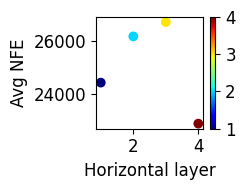

In [8]:
# Perform forward pass and compute output
y_dynn = dynn.predict(inputs, timesteps, params)

# Plot: Avg number of function evaluations in each horizontal layer.
dynn.plot_NFE(figname="ex_sp", fig_size=(2.5, 2), fontsize=12)

In [9]:
# Simulate the LTI system using python routine lsim
if u_interp == "sample":
    t = timesteps
    i = np.arange(0, d_in, 1)
    u = u(np.reshape(t, (len(t), 1)), np.reshape(i, (1, len(i))))

y_lsim = numerical_simulation_lsim(timesteps, u, ssm, interp=True)

# Simulate the LTI system using python routine solve_ivp
y_solve_ivp, nfe_solver = numerical_simulation_ivp_solve(
    ssm,
    inputs,
    timesteps,
    u_interp,
    outer_loop,
    rtol=ode_solver_rel_tol,
    atol=ode_solver_abs_tol,
)

In [10]:
# Compute relative and absolute errors
abs_err_lsim = abs(y_dynn - y_lsim)
print("Max absolute error (DyNN and solver:lsim) :", np.amax(abs_err_lsim))

abs_err_solve_ivp = abs(y_dynn - y_solve_ivp)
print("Max absolute error (DyNN and solver:solve_ivp) :", np.amax(abs_err_solve_ivp))

abs_err_between_solvers = abs(y_lsim - y_solve_ivp)
print("Max absolute error between solvers :", np.amax(abs_err_between_solvers))

Max absolute error (DyNN and solver:lsim) : 2.3271862336082805e-06
Max absolute error (DyNN and solver:solve_ivp) : 2.3268623697836333e-06
Max absolute error between solvers : 7.408970276179261e-07


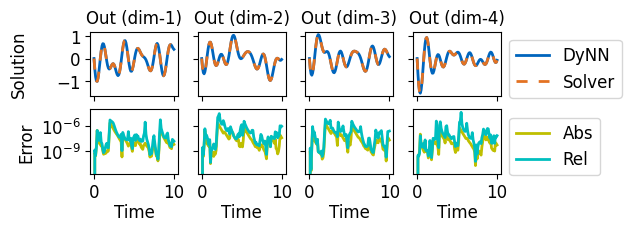

In [11]:
plot_output_and_erros(
    timesteps, y_dynn, y_lsim, fig_size=(6.2, 2.2), save_fig=True, fig_name="sp_cond_new.pdf", fontsize=12,labelpad =20
)